# Air quality index data exploration

City of Helsinki does hourly recording of the air quality within the city region. The measuement data is available as open data in https://hri.fi/data/fi/dataset/paakaupunkiseudun-ilmanlaatuindeksit

## Air quality index definition

(https://www.hsy.fi/fi/asiantuntijalle/ilmansuojelu/ilmanlaatutiedotus/Sivut/Ilmanlaatuindeksi.aspx)

Tha main purpose of the index is to provide a simple verbal descirption with color coding that can be used when communicating the current air quality to the citizens. Air quality index is divided into five classes: from good to very bad. The air quality index classes describes what kind of health implications the corresponding class has. In addition the air quality index uses multiple international norms.

The air quality index is calculated as a combination of multiple air pollution measurements. At the moment the index is calculated from the following concentration measurements:

* sulfurdioxside (SO2)
* nitrogendioxcide (NO2)
* amount inhalable particles (PM10)
* amount of micro-particles (PM2.5)
* carbonmono-oxside (CO)
* ozone (O3) 

The underlying table summarizes the verbal descriptions (with color coding) and numerical values of the air quality index with potential health and environment implications:

| Air quality  | Index value | Potential health implications  | Other implications   |  
|---|---|---|---|
| <span style="color:purple">Very bad</span>  | >150 |Possible for sensitive demographics  | Clear implications for vegetation and materials in the long run   | 
| <span style="color:red">Bad</span>  | 101-150 |Possible for sensitive individuals  | Clear implications for vegetation and materials in the long run  |  
| <span style="color:orange">Tolerable</span> | 76-100 | Unlikely  | Clear implications for vegetation and materials in the long run  |
| <span style="color:yellow">Satisfactory</span> | 51-75 | Very unlikely  | Clear implications for vegetation and materials in the long run  |
| <span style="color:green">Good</span>  | < 50 |Not observed   | Mild implications for vegetation and materials in the long run  |



 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from scipy import stats

%matplotlib inline

In [2]:
# Read data files
df_2014 = pd.read_csv("data/air-quality-index-2014.csv", sep=";")
df_2015 = pd.read_csv("data/air-quality-index-2015.csv", sep=";")
df_2016 = pd.read_csv("data/air-quality-index-2016.csv", sep=";")
df_2017 = pd.read_csv("data/air-quality-index-2017.csv", sep=";")
df_2018 = pd.read_csv("data/air-quality-index-2018.csv", sep=";")
df_2019 = pd.read_csv("data/air-quality-index-2019.csv", sep=";")
df_2019.head()

,Timestamp,Mannerheimintie,Mäkelänkatu,Kallio,Vartiokylä,Leppävaara,Tikkurila,Luukki,Lohja,Kirkkonummi,Länsisatama,Pirkkola,Friisilä,Talvikkitie
0,01/01/2019 01:00,53,52,54,55,51,47,56,9,13,0,10,0,NoData
1,01/01/2019 02:00,30,53,56,55,12,17,56,6,13,0,22,0,NoData
2,01/01/2019 03:00,22,53,56,56,5,7,56,6,8,0,15,0,NoData
3,01/01/2019 04:00,22,53,55,55,4,12,56,6,6,0,5,0,NoData
4,01/01/2019 05:00,12,51,54,54,9,8,55,6,2,0,0,0,NoData


Data contains air quality index from different measuring stations. Since we are only interested about the Helsinki city center we will only keep data from "Mannerheimintie" measuring station. Also measuring time needs to be edited so that it can be used as datetime index.

In [3]:
# clean up timestamps, extract only relevant columns & use timestamp as index
# finally drop NAs
def clean_dataframe(df):
    timestamp_pat = '(?P<day>\d{2})/(?P<month>\d{2})/(?P<year>\d{4}) +(?P<hour>\d{2}):(?P<minute>\d{2})'
    df["Timestamp"] = pd.to_datetime(df["Timestamp"].str.extract(timestamp_pat, expand=True))
    df = df.filter(["Timestamp", "Mannerheimintie"])
    df = df.set_index("Timestamp")
    df.dropna(inplace=True)
    
    return df

In [4]:
df_2014 = clean_dataframe(df_2014)
df_2015 = clean_dataframe(df_2015)
df_2016 = clean_dataframe(df_2016)
df_2017 = clean_dataframe(df_2017)
df_2018 = clean_dataframe(df_2018)
df_2019 = clean_dataframe(df_2019)
df_2019.tail()

,Mannerheimintie
Timestamp,
2019-05-31 20:00:00,31
2019-05-31 21:00:00,20
2019-05-31 22:00:00,19
2019-05-31 23:00:00,13
2019-06-01 00:00:00,19


After cleaning combine all years into a single data frame.

In [5]:
df = pd.concat([df_2014, df_2015, df_2016, df_2017, df_2018, df_2019])
df.sort_index(inplace=True)
print(df.head())
print(df.tail())

                    Mannerheimintie
Timestamp                          
2014-01-01 01:00:00              78
2014-01-01 02:00:00              68
2014-01-01 03:00:00              60
2014-01-01 04:00:00              48
2014-01-01 05:00:00              51
                    Mannerheimintie
Timestamp                          
2019-05-31 20:00:00              31
2019-05-31 21:00:00              20
2019-05-31 22:00:00              19
2019-05-31 23:00:00              13
2019-06-01 00:00:00              19


And for visualization change air quality index into numeric data.

In [6]:
df = df.convert_objects(convert_numeric=True)
print(df.head())
print(df.tail())

                     Mannerheimintie
Timestamp                           
2014-01-01 01:00:00             78.0
2014-01-01 02:00:00             68.0
2014-01-01 03:00:00             60.0
2014-01-01 04:00:00             48.0
2014-01-01 05:00:00             51.0
                     Mannerheimintie
Timestamp                           
2019-05-31 20:00:00             31.0
2019-05-31 21:00:00             20.0
2019-05-31 22:00:00             19.0
2019-05-31 23:00:00             13.0
2019-06-01 00:00:00             19.0


/Users/aapo/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  To re-infer data dtypes for object columns, use DataFrame.infer_objects()
For all other conversions use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.


Let's see some descriptive statistics for the data. 

In [7]:
df.describe()

,Mannerheimintie
count,47352.000000
mean,51.416836
std,17.757935
min,0.000000
25%,40.000000
50%,52.000000
75%,62.000000
max,565.000000


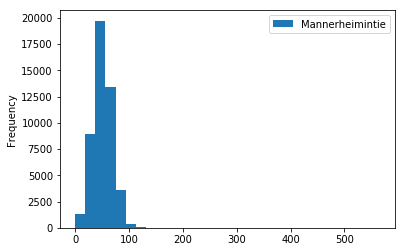

In [8]:
df.plot.hist(bins=30)

In [9]:
print("Skewness of the air quality index values: {}".format(df.skew()))
print("Kurtosis of the air quality index values: {}".format(df.kurtosis()))

Skewness of the air quality index values: Mannerheimintie    0.990656
dtype: float64
Kurtosis of the air quality index values: Mannerheimintie    18.406763
dtype: float64


So the data has moderate positive skew and quite high kurtosis implying long tail. Let's see if we remove outliers.

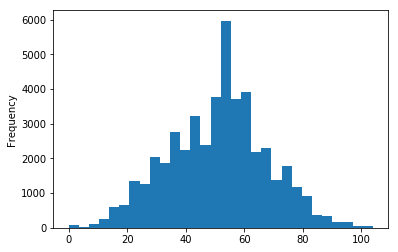

In [10]:
# drop outliers
df1 = df.copy()
df1["z"] = (df1.Mannerheimintie - df1.Mannerheimintie.mean())/df1.Mannerheimintie.std(ddof=0)
df1 = df1.loc[df1['z'] < 3]
df1["Mannerheimintie"].plot.hist(bins=30)

In [11]:
df1.drop("z", axis=1, inplace=True)
df1.describe()

,Mannerheimintie
count,47157.000000
mean,51.092054
std,16.816586
min,0.000000
25%,40.000000
50%,52.000000
75%,61.000000
max,104.000000


In [12]:
print("Skewness of the air quality index values after removing outliers: {}".format(df1.skew()))
print("Kurtosis of the air quality index values after removing outliers: {}".format(df1.kurtosis()))

Skewness of the air quality index values after removing outliers: Mannerheimintie   -0.030316
dtype: float64
Kurtosis of the air quality index values after removing outliers: Mannerheimintie   -0.111813
dtype: float64


So after removinh outliers the data is quite close to be normally distributed. This was expected since it makes sens that the air quality index is "average" or close to average on most days.

Let's plot the time series to see if there is a trend.

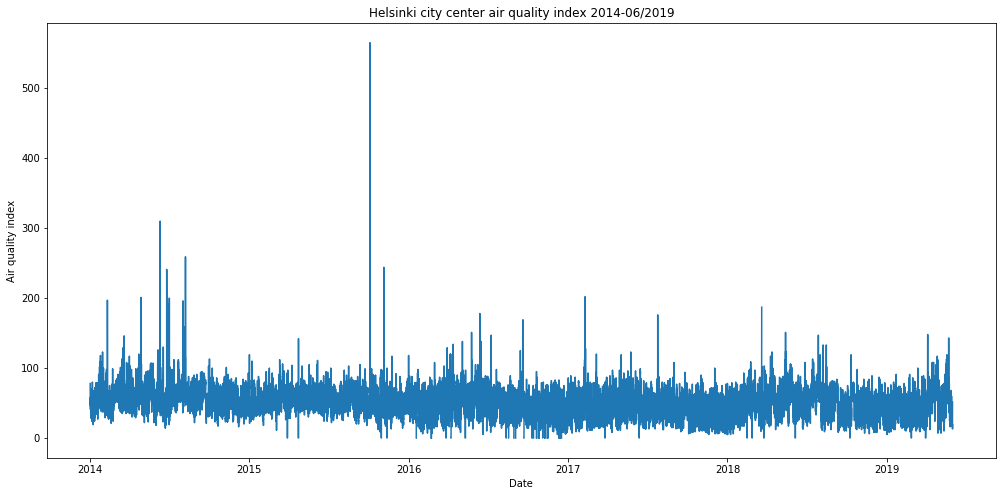

In [13]:
plt.figure(figsize=(17,8))
plt.plot(df["Mannerheimintie"])
plt.title("Helsinki city center air quality index 2014-06/2019")
plt.xlabel("Date")
plt.ylabel("Air quality index")
plt.grid(False)
plt.show()

Well, there is so many data point that it is impossible to see any repeating trend. To get better understanding of the data lets resample the time series monthly and visualise.

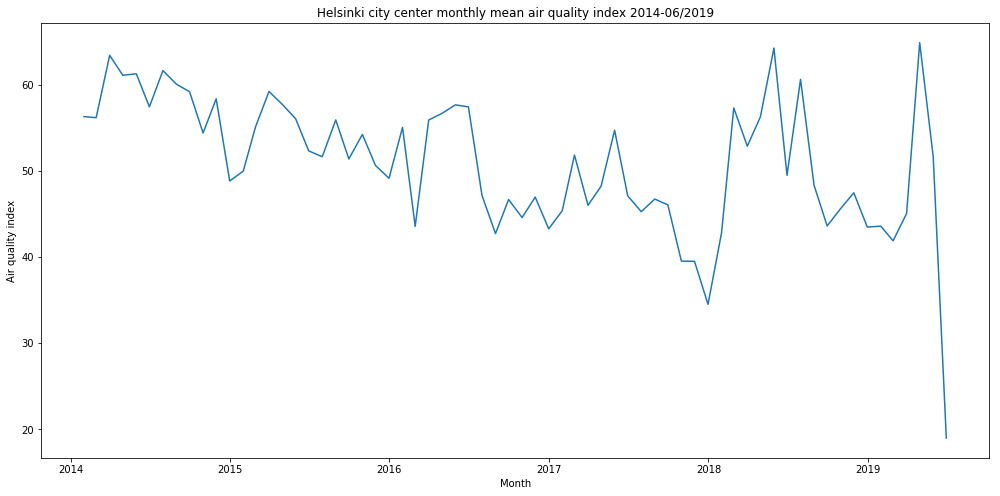

In [14]:
# resample for Monthly
df_month = df.resample("M").mean()
plt.figure(figsize=(17,8))
plt.plot(df_month["Mannerheimintie"])
plt.title("Helsinki city center monthly mean air quality index 2014-06/2019")
plt.xlabel("Month")
plt.ylabel("Air quality index")
plt.grid(False)
plt.show()

From this it sort of looks like that the overall air quality was improving from 2014->2017 but then got worse during 1st half of 2018.

Finally lets see how the time series data is correlated.

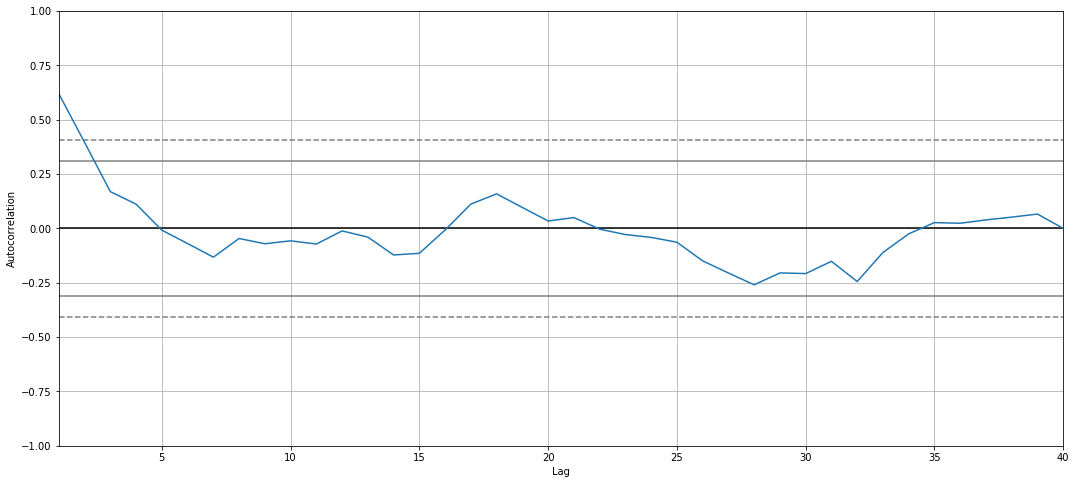

In [15]:
plt.figure(figsize=(18,8))
autocorrelation_plot(df["Mannerheimintie"].iloc[:40])

So based on the autocorrelation plot the given data point is correlated with 2-3 previous measurements and random after that. We can use this information in modelling.

Next let's incorporate the weather information and see if it affects the air quality index

In [16]:
weather_2014 = pd.read_csv("data/weather-2014.csv", sep=",")
weather_2015 = pd.read_csv("data/weather-2015.csv", sep=",")
weather_2016 = pd.read_csv("data/weather-2016.csv", sep=",")
weather_2017 = pd.read_csv("data/weather-2017.csv", sep=",")
weather_2018 = pd.read_csv("data/weather-2018.csv", sep=",")
weather_2019 = pd.read_csv("data/weather-2019.csv", sep=",")
weather_2019.head()

,Vuosi,Kk,Pv,Klo,Aikavyöhyke,Ilmanpaine (msl) (hPa),Suhteellinen kosteus (%),Sateen intensiteetti (mm/h),Ilman lämpötila (degC),Tuulen suunta (deg),Tuulen nopeus (m/s)
0,2019,1,1,00:00,UTC,1000.9,94.0,0.5,1.4,207.0,8.4
1,2019,1,1,01:00,UTC,998.7,95.0,0.2,2.0,210.0,8.0
2,2019,1,1,02:00,UTC,996.5,96.0,0.0,2.5,212.0,8.3
3,2019,1,1,03:00,UTC,994.2,96.0,0.0,2.8,209.0,8.0
4,2019,1,1,04:00,UTC,991.9,97.0,0.0,3.0,206.0,7.6


In [17]:
# clean up weather data
def clean_weather_data(df):
    time_data = df.Klo.str.split(":", n = 1, expand = True)
    df["Tunti"] = time_data[0]
    df["Minuutti"] = time_data[1]
    df["Timestamp"] = pd.to_datetime(dict(year=df.Vuosi, month=df.Kk, 
                                          day=df.Pv, hour=df.Tunti,
                                          minute=df.Minuutti))
    df.drop("Vuosi", axis=1, inplace=True)
    df.drop("Kk", axis=1, inplace=True)
    df.drop("Pv", axis=1, inplace=True)
    df.drop("Klo", axis=1, inplace=True)
    df.drop("Aikavyöhyke", axis=1, inplace=True)
    df.drop("Tunti", axis=1, inplace=True)
    df.drop("Minuutti", axis=1, inplace=True)

    cols = ["Ilmanpaine (msl) (hPa)", "Suhteellinen kosteus (%)", "Sateen intensiteetti (mm/h)",
            "Ilman lämpötila (degC)", "Tuulen suunta (deg)", "Tuulen nopeus (m/s)"]
    df[cols] = df[cols].apply(pd.to_numeric, errors='coerce', axis=1) 
    
    df = df.rename(columns = { 
                "Ilmanpaine (msl) (hPa)": "Air pressure (msl) (hPa)", 
                "Suhteellinen kosteus (%)": "Relative humidity (%)",
                "Sateen intensiteetti (mm/h)": "Rain intensity (mm/h)",
                "Ilman lämpötila (degC)": "Air temperature (degC)",
                "Tuulen suunta (deg)": "Wind direction (deg)",
                "Tuulen nopeus (m/s)": "Wind speed (m/s)"
    })

    df = df.set_index("Timestamp")
    df.dropna(inplace=True)

    return df

In [18]:
weather_2014 = clean_weather_data(weather_2014)
weather_2015 = clean_weather_data(weather_2015)
weather_2016 = clean_weather_data(weather_2016)
weather_2017 = clean_weather_data(weather_2017)
weather_2018 = clean_weather_data(weather_2018)
weather_2019 = clean_weather_data(weather_2019)
weather_2019.tail()

,Air pressure (msl) (hPa),Relative humidity (%),Rain intensity (mm/h),Air temperature (degC),Wind direction (deg),Wind speed (m/s)
Timestamp,,,,,,
2019-07-22 20:00:00,1014.9,78.0,0.0,18.7,323.0,1.8
2019-07-22 21:00:00,1014.9,80.0,0.0,18.3,321.0,1.8
2019-07-22 22:00:00,1015.0,84.0,0.0,17.4,330.0,1.8
2019-07-22 23:00:00,1015.1,85.0,0.0,16.8,353.0,1.2
2019-07-23 00:00:00,1015.2,88.0,0.0,16.4,22.0,1.9


In [19]:
weather = pd.concat([weather_2014, weather_2015, weather_2016, weather_2017, weather_2018, weather_2019])
weather.sort_index(inplace=True)


In [20]:
weather.tail()

,Air pressure (msl) (hPa),Relative humidity (%),Rain intensity (mm/h),Air temperature (degC),Wind direction (deg),Wind speed (m/s)
Timestamp,,,,,,
2019-07-22 20:00:00,1014.9,78.0,0.0,18.7,323.0,1.8
2019-07-22 21:00:00,1014.9,80.0,0.0,18.3,321.0,1.8
2019-07-22 22:00:00,1015.0,84.0,0.0,17.4,330.0,1.8
2019-07-22 23:00:00,1015.1,85.0,0.0,16.8,353.0,1.2
2019-07-23 00:00:00,1015.2,88.0,0.0,16.4,22.0,1.9


Use Pandas merge functionality to combine data frames. Since both use the datetime index we can map the hourly measurements.

In [21]:
aqi_weather = pd.merge_asof(df, weather, left_index=True, right_index=True)
aqi_weather.head()

,Mannerheimintie,Air pressure (msl) (hPa),Relative humidity (%),Rain intensity (mm/h),Air temperature (degC),Wind direction (deg),Wind speed (m/s)
Timestamp,,,,,,,
2014-01-01 01:00:00,78.0,1016.8,89.0,0.0,5.1,253.0,4.9
2014-01-01 02:00:00,68.0,1016.8,87.0,0.0,5.1,255.0,5.6
2014-01-01 03:00:00,60.0,1016.9,85.0,0.0,5.2,246.0,5.3
2014-01-01 04:00:00,48.0,1016.9,86.0,0.0,5.2,254.0,5.7
2014-01-01 05:00:00,51.0,1017.1,89.0,0.0,5.1,249.0,4.3


Let's plot a correlation matrix to see how strongly the air quality index is correlated with weather.

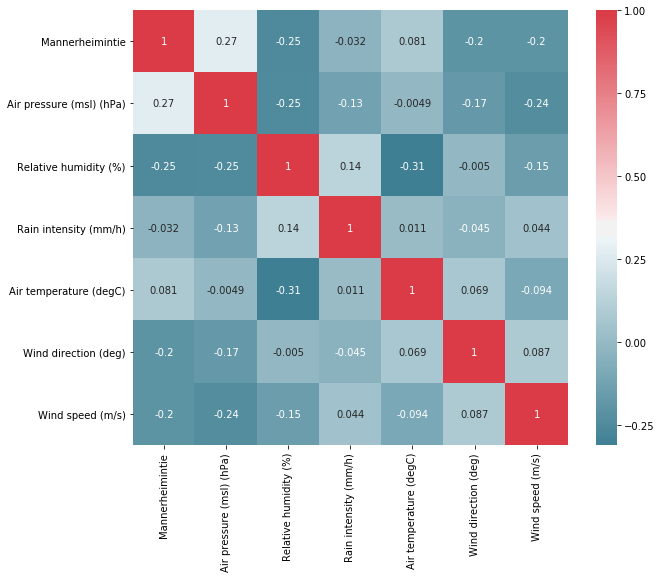

In [22]:
f, ax = plt.subplots(figsize=(10, 8))
corr = aqi_weather.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

Suprisingly weather data is not very strongly correlated. From this we can conclude that weather information might be used as an extra features for air quality index prediction.

Next let's see how traffic data is related to the air quality index. Unfortunately we only have average number of car per hour per year (i.e. no daily data) so we need to calculate average air quality indes per hour per year.

In [23]:
def fix_traffic_time(time_str):
    if time_str == 0:
        return "00:00"
    else:
        hour = int(time_str/100)
        return "{}:{}".format(str(hour).rjust(2, '0'), str(time_str - (hour * 100)).ljust(2, '0'))

In [24]:
traffic = pd.read_csv("data/traffic_data.csv", sep=";")
traffic = traffic[traffic["nimi"]=="MANNERHEIMINTIE"]
traffic = traffic.filter(["nimi", "aika", "vuosi", "autot"])
traffic["aika"] = traffic["aika"].apply(fix_traffic_time)
traffic["aika"] = pd.to_datetime(traffic["aika"],format= '%H:%M' ).dt.time
traffic = traffic.rename(columns={ "nimi": "name", "aika": "time", "vuosi": "year", "autot": "cars"})
traffic = traffic.reset_index()
traffic = traffic.drop("index", axis=1)
traffic["time"] = traffic["time"].astype(str)
traffic["year"] = traffic["year"].astype(str)

traffic.head()

,name,time,year,cars
0,MANNERHEIMINTIE,00:00:00,2011,230
1,MANNERHEIMINTIE,01:00:00,2011,154
2,MANNERHEIMINTIE,02:00:00,2011,145
3,MANNERHEIMINTIE,03:00:00,2011,132
4,MANNERHEIMINTIE,04:00:00,2011,148


In [25]:
import datetime

def combine_with_traffic(aqi, traffic):
    dfs = []
    for year in ["2014", "2015", "2016", "2017", "2018"]:
        bstr = "{}0101".format(year)
        estr = "{}1231".format(year)
        df1 = aqi[bstr:estr]
        df2 = traffic[traffic["year"] == year]
        for i in range(24):
            ctime = datetime.time(i, 0)
            aqi_mean = df1.at_time(ctime).mean().values[0]
            cars = df2[df2["time"] == str(ctime)]
            ncars = cars["cars"].sum()
            dfs.append(pd.DataFrame({"year": [year], "time": [str(ctime)], 
                                     "air quality index mean": [aqi_mean], 
                                     "number of cars": [ncars]}))
    return pd.concat(dfs, ignore_index=True)

In [26]:
d = combine_with_traffic(df, traffic)
d.head()


,year,time,air quality index mean,number of cars
0,2014,00:00:00,54.634615,560
1,2014,01:00:00,54.690411,414
2,2014,02:00:00,56.013736,327
3,2014,03:00:00,55.260989,307
4,2014,04:00:00,54.019231,335


In [27]:
aqi_traffic = d.filter(["air quality index mean", "number of cars"])
aqi_traffic.head()

,air quality index mean,number of cars
0,54.634615,560
1,54.690411,414
2,56.013736,327
3,55.260989,307
4,54.019231,335


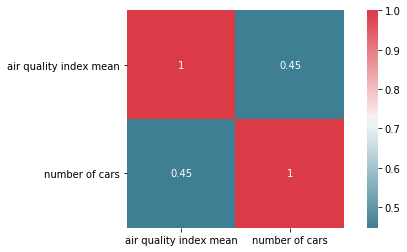

In [28]:
f, ax = plt.subplots(figsize=(8, 4))
corr = aqi_traffic.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

And as we can see from the correlation matrix the amount of traffic is somewhat positively correlated with the air quality index. Unfortunately our traffic data is not very good so this correlation is only an approximation.